<font size = 6>$\Delta$CoVaR Estimation </font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> May 6, 2022</div></font>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import math
import scipy
import nlopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import statsmodels.api as sma
from statsmodels.regression.quantile_regression import QuantReg as qr
from datetime import datetime

<font size = 4>Please make sure to input your Data path in your computer in the following format</font>

In [3]:
path = "D:\\Data\\"

<font size = 4>Please make sure to research time period in your computer in the following format:\
By the way, however, S&P 500 real estate sector index data before 2002/2/11 and after 2021/12/31 is not available!</font>

In [4]:
start = dt.datetime(year=2002, month=12, day=31)
end = dt.datetime(year=2021, month=12, day=31)

<font size = 4>Linux Debug Environment</font>

In [5]:
#! pip install nlopt
#! pip install yfinance
#! pip install pandas_datareader

In [6]:
#path = "/home/jovyan/demo/Data/"

# VaR Calculation

In [33]:
window_size = 52 * 3

## Nonparametric method - Historical Data

In [34]:
def historical_var(stock_name, q, window_size = window_size, stocks_losses_series = stocks_losses_W_pct):
    return stocks_losses_series[stock_name].dropna().rolling(
        window = window_size, min_periods = int(0.8 * window_size)
    ).apply(lambda x: np.quantile(x, q)).dropna().rename(stock_name + "_VaR_" + str(q))

## Semiparametric method - Formula 

In [35]:
def formula_var(stock_name, q, window_size = window_size, stocks_losses_series = stocks_losses_W_pct):
    rolling = stocks_losses_series[stock_name].dropna().rolling(window = window_size, min_periods = int(0.8 * window_size))
    mean_series = rolling.mean()
    std_series = rolling.std()
    return (mean_series + scipy.stats.norm.ppf(q) * std_series).dropna().rename(stock_name + "_VaR_" + str(q))

## Parametric method - MLE

In [36]:
def Trs(df):
    return np.array(df.T)[0]

def regularize(series_i, market_losses_series, state_variables_series):
    series_i = series_i.dropna().copy()
    mkt = market_losses_series.copy()
    svs_lagged = state_variables_series.copy().shift(1).dropna()
    common = svs_lagged.index.intersection(series_i.index)
    mkt = mkt.loc[common,:]
    series_i = series_i.loc[common]
    svs_lagged = svs_lagged.loc[common,:]
    return series_i, mkt, svs_lagged

In [37]:
def log_likelihood_norm(params, series_i, mkt, svs_lagged):
    pi = math.pi
    n = series_i.shape[0]
    mu, sigma, p0, p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6, p2, p3, p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6, p5 = params
    p1_v = np.array([p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6])
    p4_v = np.array([p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6])

    part1 = (-n) * np.log(sigma)
    part2 = (-n / 2) * np.log(2 * pi)
    part3 = (-1.0 / 2 / np.power(sigma, 2)) * (sum(np.power(
            mu - (Trs(mkt) - p0 - p1_v.dot(svs_lagged.T) - p2 * Trs(series_i))
                / (p3 + p4_v.dot(svs_lagged.T) + p5 * Trs(series_i)), 2)))
    ll = part1 + part2 + part3
    return ll

In [38]:
def fit_mle_norm(series_i, mkt, svs_lagged, initial_guess = None):

    def mle_objective(temp, grad):
        assert len(grad) == 0
        assert len(temp) == 20
        return -log_likelihood_norm(temp, series_i, mkt, svs_lagged)

    lb = [-10, 0] + [-10] + [-1, -5, -0.3, -6, -4, -3, -10] + [-5, -10] + [-1, -5, -0.3, -6, -4, -3, -10] + [-5]
    ub = [10, 10] + [10] + [1, 5, 0.3, 6, 4, 3, 10] + [5, 10] + [1, 5, 0.3, 6, 4, 3, 10] + [5]
    opt = nlopt.opt(nlopt.LN_COBYLA, 20)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_min_objective(mle_objective)
    opt.set_xtol_rel(1e-2)
    opt.set_ftol_abs(1e-3)

    if initial_guess is None:
        x0 = [0.2] * 20
    else:
        x0 = initial_guess
    x = opt.optimize(x0)

    assert opt.last_optimize_result() in [nlopt.SUCCESS, nlopt.FTOL_REACHED, nlopt.XTOL_REACHED]
    # print(x)
    return x

In [39]:
def MLE_var_result(params, stock_name, q, series_i, mkt, svs_lagged):
    mu, sigma, p0, p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6, p2, p3, p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6, p5 = params
    p1_v = np.array([p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6])
    p4_v = np.array([p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6])

    loc_series = p0 + p1_v.dot(svs_lagged.T) + p2 * Trs(series_i)
    scale_series = p3 + p4_v.dot(svs_lagged.T) + p5 * Trs(series_i)
    err_series = (Trs(mkt) - loc_series) / scale_series
    var_series = []
    for i in range(err_series.shape[0]):
        var_series.append(scipy.stats.norm(loc_series[i] + mu * scale_series[i], scale_series[i] * sigma).ppf(q))
    loc_series = pd.Series(loc_series, index = mkt.index, name = "loc")
    scale_series = pd.Series(scale_series, index = mkt.index, name = "scale")
    var_series = pd.Series(var_series, index = mkt.index, name = stock_name + "_VaR_" + str(q))
    error_series = pd.Series(err_series, index = mkt.index, name = "error_term")
    return var_series, (mu, sigma), pd.concat([var_series, error_series, loc_series, scale_series], axis = 1)

In [40]:
def MLE_var(stock_name, q,
            market_losses_series = market_losses_W_pct,
            stocks_losses_series = stocks_losses_W_pct,
            state_variables_series = stateVariables_W):

    stk, mkt, svs_lagged = regularize(stocks_losses_series[stock_name], market_losses_series, state_variables_series)
    params = fit_mle_norm(stk, mkt, svs_lagged)
    return MLE_var_result(params, stock_name, q, stk, mkt, svs_lagged)

## Parametric method - Quantile Regression

In [41]:
def qr_var(stock_name, q, modified = True,
           state_variables_series = stateVariables_W,
           stocks_losses_series = stocks_losses_W_pct):

    stk = stocks_losses_series[stock_name].dropna().copy()
    svs_lagged = state_variables_series.copy().shift(1).dropna()
    if modified:
        stk_lagged = stk.shift(1).dropna()
        common = stk_lagged.index.intersection(svs_lagged.index)
        stk = stk.loc[common]
        reg = svs_lagged.loc[common,:]
        reg["stock_lagged"] = stk_lagged.loc[common]
    else:
        common = stk.index.intersection(svs_lagged.index)
        stk = stk.loc[common]
        reg = svs_lagged.loc[common,:]

    qr_model = qr(stk, sma.add_constant(reg)).fit(q)
    qr_var_values = qr_model.fittedvalues.rename(stock_name + "_VaR_" + str(q))
    return qr_var_values, qr_model

## Summary Function

In [42]:
def var(stock_name, q, qr_var_method, qr_var_modified = True):
    if qr_var_method != qr_var and qr_var_modified == False:
        raise Exception("Input Error! Only Quantile Regression VaR model can be modified!")
    if qr_var_method == qr_var:
        if qr_var_modified:
            stk_var = qr_var_method(stock_name, q)[0]
        else:
            stk_var = qr_var_method(stock_name, q, modified = False)[0]
    elif qr_var_method == MLE_var:
        stk_var = qr_var_method(stock_name, q)[0]
    else:
        stk_var = qr_var_method(stock_name, q)
    return stk_var

# $\Delta$CoVaR Calculation

## Quantile Regression

In [43]:
def qr_covar(stock_name, q, qr_var_method, qr_var_modified = True,
             state_variables_series = stateVariables_W,
             market_losses_series = market_losses_W_pct):

    stk_var = var(stock_name, q, qr_var_method, qr_var_modified)
    mkt = market_losses_series.copy()
    svs_lagged = state_variables_series.copy().shift(1).dropna()

    common = svs_lagged.index.intersection(stk_var.index)
    mkt = mkt.loc[common,:]
    reg = svs_lagged.loc[common,:]
    reg[stk_var.name] = stk_var.loc[common]

    qr_model = qr(mkt, sma.add_constant(reg)).fit(q)
    qr_covar_values = qr_model.fittedvalues.rename(stock_name + "_CoVaR_" + str(q))

    return qr_covar_values, qr_model, stk_var

In [44]:
def qr_delta_covar(stock_name, q, qr_var_method, qr_var_modified = True,
                   formula_alter = True):

    if q <= 0.5 and q >= 1:
        raise Exception("Input Error! q should be in (0.5, 1)!")

    if formula_alter:
        _, qr_model_q, stk_var = qr_covar(stock_name, q, qr_var)
        var_median = qr_covar(stock_name, 0.5, qr_var)[2]
        return ((stk_var - var_median) * qr_model_q.params[-1]).rename(stock_name + "_\u0394CoVaR_" + str(q) + "_formula2"), stk_var
    else:
        covar_qr, _, stk_var = qr_covar(stock_name, q, qr_var)
        temp = covar_qr - qr_covar(stock_name, 0.5, qr_var)[0]
        return temp.rename(stock_name + "_\u0394CoVaR_" + str(q) + "_formula1"), stk_var

## MLE (Maximum Likelihood Estimation)

In [45]:
def MLE_covar_result(params, stock_name, q, series_i, mkt, svs_lagged):
    mu, sigma, p0, p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6, p2, p3, p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6, p5 = params
    p1_v = np.array([p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6])
    p4_v = np.array([p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6])

    loc_series = p0 + p1_v.dot(svs_lagged.T) + p2 * Trs(series_i)
    scale_series = p3 + p4_v.dot(svs_lagged.T) + p5 * Trs(series_i)
    err_series = (Trs(mkt) - loc_series) / scale_series
    covar_series = []
    for i in range(err_series.shape[0]):
        covar_series.append(scipy.stats.norm(loc_series[i] + mu * scale_series[i], scale_series[i] * sigma).ppf(q))
    loc_series = pd.Series(loc_series, index = mkt.index, name = "loc")
    scale_series = pd.Series(scale_series, index = mkt.index, name = "scale")
    covar_series = pd.Series(covar_series, index = mkt.index, name = stock_name + "_CoVaR_" + str(q))
    error_series = pd.Series(err_series, index = mkt.index, name = "error_term")
    return covar_series, (mu, sigma), pd.concat([covar_series, error_series, loc_series, scale_series], axis = 1)

In [46]:
def MLE_covar(stock_name, q, qr_var_method, qr_var_modified = True,
              state_variables_series = stateVariables_W,
              market_losses_series = market_losses_W_pct):

    stk_var = var(stock_name, q, qr_var_method, qr_var_modified)
    var_i, mkt, svs_lagged = regularize(stk_var, market_losses_series, state_variables_series)
    params = fit_mle_norm(var_i, mkt, svs_lagged)
    return MLE_covar_result(params, stock_name, q, var_i, mkt, svs_lagged)

In [47]:
def MLE_delta_covar(stock_name, q, qr_var_method, qr_var_modified = True):
    if q <= 0.5 and q >= 1:
        raise Exception("Input Error! q should be in (0.5, 1)!")
    covar_MLE, stk_var = MLE_covar(stock_name, q, qr_var_method, qr_var_modified)[:2]
    temp = covar_MLE - MLE_covar(stock_name, 0.5, qr_var_method, qr_var_modified)[0]
    return temp.rename(stock_name + "_\u0394CoVaR_" + str(q)), stk_var

# Empirical Study

## MLE Algorithm Robustness Testing

In [48]:
def var_params_MLE(stock_name, 
              market_losses_series = market_losses_W_pct, 
              stocks_losses_series = stocks_losses_W_pct, 
              state_variables_series = stateVariables_W):
    stk, mkt, svs_lagged = regularize(stocks_losses_series[stock_name], market_losses_series, state_variables_series)
    return fit_mle_norm(stk, mkt, svs_lagged), stk, mkt, svs_lagged

In [49]:
max_values = pd.DataFrame(columns = ["Max_Params", "Test_Params"])
params = pd.DataFrame(columns = list(stocks_losses_W_pct.columns))
for stock_name in list(stocks_losses_W_pct.columns):
    params[stock_name], stk, mkt, svs_lagged = var_params_MLE(stock_name)
    test_params = params[stock_name].copy()
    test_params[:] = [3, 1, 0, 0.3, -2, -0.2, 4, -2, -1, -9, 4, 8, -0.7, 1, 0.1, -2, 1, 2, 7, 3]
    max_values.loc[stock_name, "Max_Params"] = log_likelihood_norm(params[stock_name], stk, mkt, svs_lagged)
    max_values.loc[stock_name, "Test_Params"] = log_likelihood_norm(test_params, stk, mkt, svs_lagged)

In [50]:
params

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
0,-0.593409,-0.312086,-0.413222,-0.141634,-0.448963,-0.302434,-0.151775,0.062371,0.220366,-0.250235,...,-0.238580,-0.316262,-0.206955,-0.638256,0.206177,-0.059334,-0.342791,-0.360442,0.209166,-0.752245
1,0.304903,0.348305,0.346725,0.248250,0.311587,0.308979,0.303314,0.303780,0.337508,0.264152,...,0.347177,0.325032,0.254997,0.212796,0.295467,0.305347,0.333449,0.328461,0.315391,0.260009
2,2.900682,-0.028710,2.378961,-2.720184,1.453672,-0.850722,-0.229370,-2.552167,-3.111008,-0.940264,...,-0.107328,-1.175360,0.048824,-0.180683,-0.900945,0.060527,-0.243206,-0.335869,-2.753388,7.124727
3,0.189153,0.188525,0.258063,0.024341,0.156796,0.118914,0.123243,0.000598,0.136935,0.041975,...,-0.162098,0.234018,0.164274,-0.043330,-0.100433,0.193989,0.042768,0.100873,0.062900,0.005246
4,0.953512,-0.047069,0.028129,0.487649,0.191251,0.407374,0.100183,0.006225,0.195955,0.130066,...,-0.140465,-0.232250,-0.081703,0.252342,0.028188,-0.270096,0.262176,0.098542,0.152388,0.235737
5,0.201684,0.194480,0.203328,0.180928,0.189693,0.208437,0.197625,0.166165,0.180771,0.198141,...,0.176940,0.193396,0.181672,0.192718,0.260920,0.177184,0.203493,0.203121,0.199417,0.271690
6,0.043302,0.323177,0.588991,-0.043655,-1.422947,0.192092,0.513455,-0.318575,-0.184435,0.327794,...,1.155302,0.735836,0.134231,0.003060,-0.177554,0.277297,-0.095870,0.502489,0.230006,0.216485
7,0.711959,0.234291,0.963591,0.031950,0.399652,1.083671,0.404721,0.089443,-0.444359,-0.005357,...,0.252600,0.504174,0.124458,0.004588,-0.470181,0.338761,0.101600,0.325555,0.310023,0.329484
8,0.384342,0.093310,0.556777,-0.055902,0.267303,0.356691,-0.112418,-0.077550,-0.061032,-0.177075,...,-0.117127,0.210439,0.255684,0.686932,-0.189749,0.129206,0.380159,0.276297,0.142917,0.162213
9,1.569032,0.518762,0.270970,0.456367,0.729194,0.682479,-0.167666,-3.527279,-3.409657,0.094243,...,-0.580183,0.825879,0.570677,-0.227252,-4.543779,0.202253,-0.998459,0.071429,-1.718285,0.688400


In [51]:
max_values
False in (max_values["Max_Params"] > max_values["Test_Params"])

,Max_Params,Test_Params
MMM,59.824164,-17957.347338
AOS,40.293151,-5589.749471
ABT,46.145184,-13205.302339
ABBV,154.673997,-43363.961696
ABMD,151.899154,-10013782.830008
...,...,...
YUM,23.248764,-648333.43476
ZBRA,48.744118,-7341.665783
ZBH,106.409432,-5367.079748
ZION,69.886101,-80872932.686062


False

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

(array([-7000., -6000., -5000., -4000., -3000., -2000., -1000.,     0.,
         1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0, 0.5, 'Log-likelihood Function values')

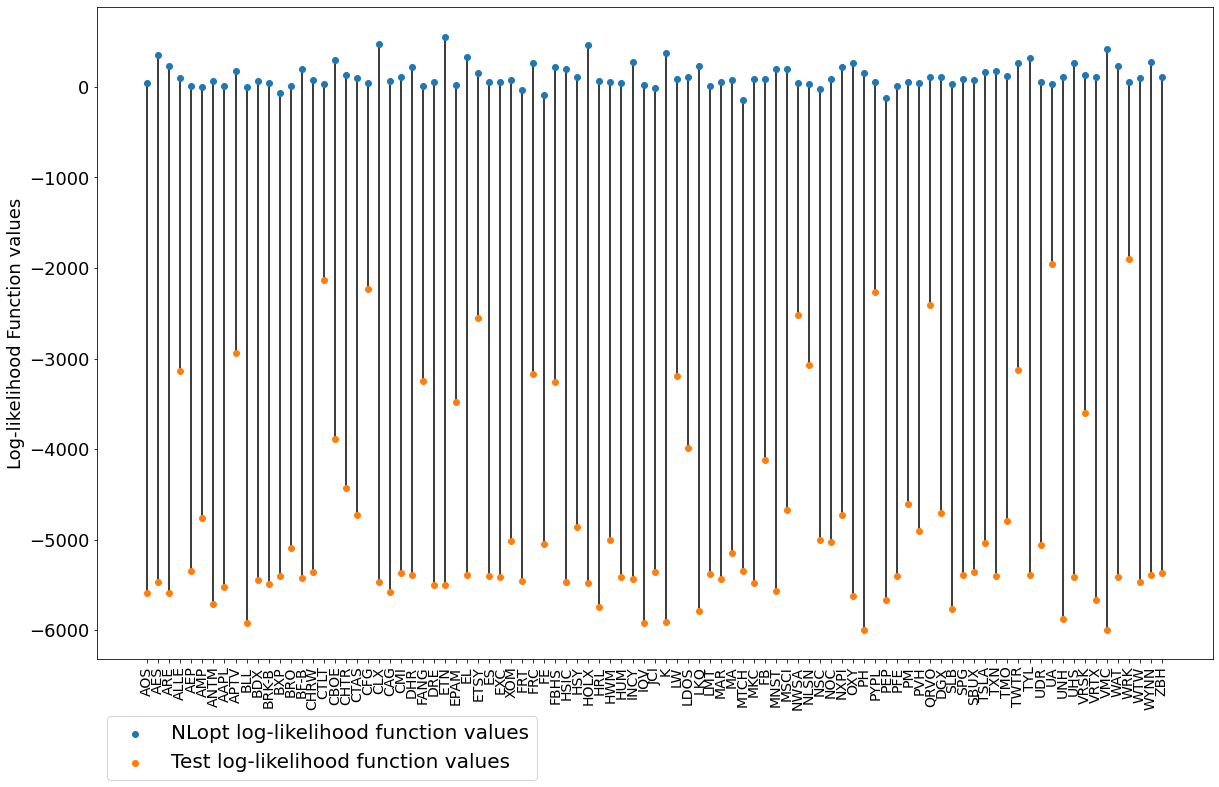

In [52]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1, 1, 1)
threshold = -6000
max_vec = max_values[max_values["Test_Params"] >= threshold].loc[:, "Max_Params"]
test_vec = max_values[max_values["Test_Params"] >= threshold].loc[:, "Test_Params"]
for i in range(max_vec.shape[0]):
    y = np.linspace(test_vec.iloc[i], max_vec.iloc[i], 100)
    ax1.plot([max_vec.index[i]] * 100, y, color = "k", zorder = 1)
ax1.scatter(max_vec.index, max_vec, zorder = 2, label = "NLopt log-likelihood function values")
ax1.scatter(test_vec.index, test_vec, zorder = 2, label = "Test log-likelihood function values")
plt.xticks(fontsize=14, rotation = 90)
plt.yticks(fontsize=18)
plt.ylabel("Log-likelihood Function values", fontsize=18)
plt.legend(bbox_to_anchor=(0,-0.2), loc="lower left", fontsize=20)

## VaR computational methods comparison

In [53]:
def var_plot(stock_name, ax, q = 0.99, sector = sector, add_legend = False):
    historical = var(stock_name, q, historical_var)
    formula = var(stock_name, q, formula_var)
    qr_author = var(stock_name, q, qr_var, False)[int(window_size * 0.8):]
    qr_modified = var(stock_name, q, qr_var)[int(window_size * 0.8):]
    plot_min = np.array([historical.min(),formula.min(),qr_author.min(),qr_modified.min()]).min() - 5
    plot_max = np.array([historical.max(),formula.max(),qr_author.max(),qr_modified.max()]).max() + 35
    MLE = var(stock_name, q, MLE_var)[int(window_size * 0.8):]

    plt.title(sector[sector.index == stock_name]["Security"].values[0] + " - From " + sector[sector.index == stock_name]["GICS\xa0Sector"].values[0] + " Sector", fontsize=20)
    plt.ylabel("percent", fontsize=18)
    plt.ylim(plot_min, plot_max)
    plt.xticks(fontsize=16, rotation = 30)
    plt.yticks(fontsize=16)
    if add_legend:
        ax.plot(historical, label=str(int(100 *q)) + '%VaR - Nonparametric method')
        ax.plot(formula, label=str(int(100 *q)) + '%VaR - Semiparametric method')
        ax.plot(qr_author, label=str(int(100 *q)) + '%VaR - Parametric method [Quantile Regression - Author]')
        ax.plot(qr_modified, alpha = 0.8, label=str(int(100 *q)) + '%VaR - Parametric method [Quantile Regression - Modified (Add lagged stock losses series)]')
        ax.plot(MLE, label=str(int(100 *q)) + '%VaR - Parametric method [MLE]')
        plt.legend(bbox_to_anchor=(0,-0.4), loc="lower left", fontsize=20)
    else:
        ax.plot(historical)
        ax.plot(formula)
        ax.plot(qr_author)
        ax.plot(qr_modified, alpha = 0.8)
        ax.plot(MLE)

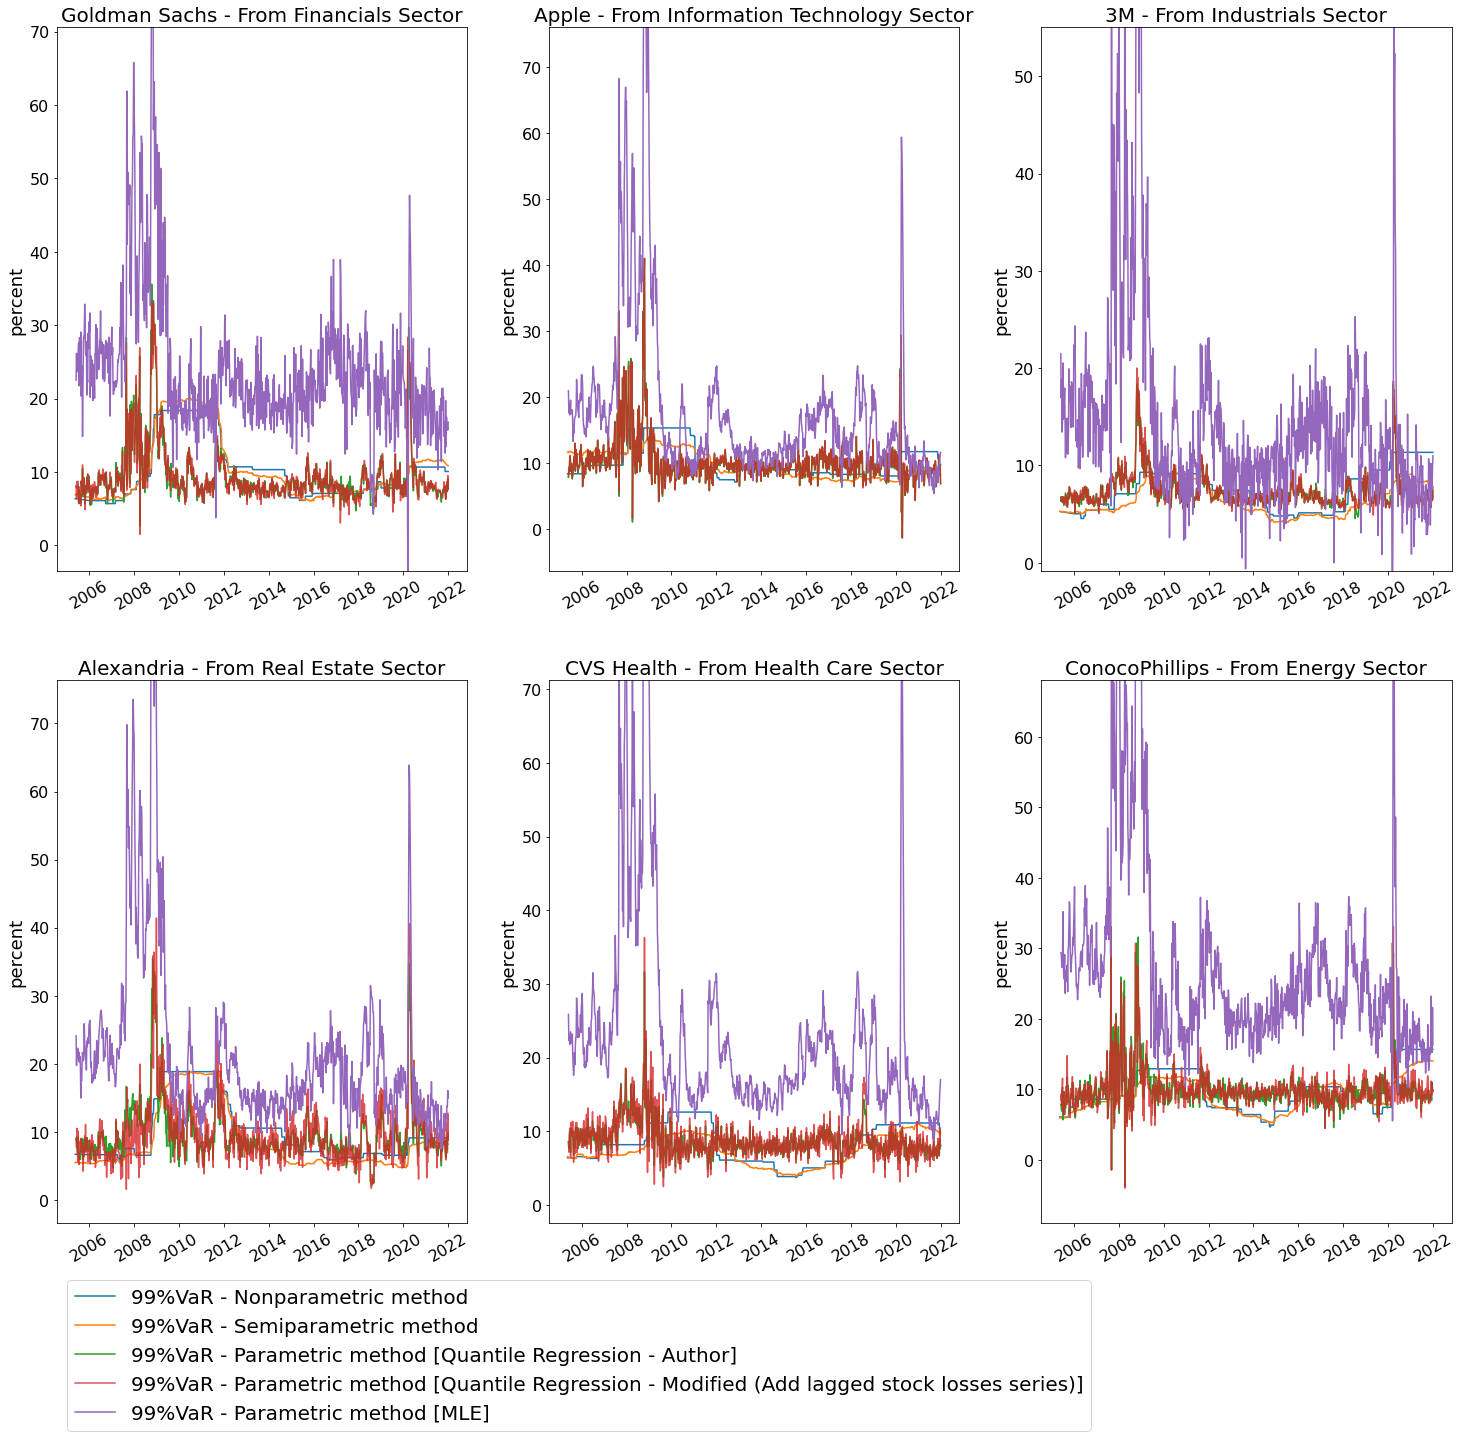

In [54]:
fig = plt.figure(figsize=(25, 22))
ax1 = fig.add_subplot(2, 3, 1)
var_plot("GS", ax1)
ax2 = fig.add_subplot(2, 3, 2)
var_plot("AAPL", ax2)
ax3 = fig.add_subplot(2, 3, 3)
var_plot("MMM", ax3)
ax4 = fig.add_subplot(2, 3, 4)
var_plot("ARE", ax4, add_legend = True)
ax5 = fig.add_subplot(2, 3, 5)
var_plot("CVS", ax5)
ax6 = fig.add_subplot(2, 3, 6)
var_plot("COP", ax6)

## CoVar computational methods comparison

In [55]:
def covar_plot(stock_name, ax, q = 0.99, sector = sector, add_legend = False):
    MLE_MLE = MLE_covar(stock_name, q, MLE_var)[0]
    qr_MLE = MLE_covar(stock_name, q, qr_var)[0]
    qr_qr = qr_covar(stock_name, q, qr_var)[0]
    MLE_qr = qr_covar(stock_name, q, MLE_var)[0]
    
    if q == 0.5:
        plot_min = np.array([qr_qr, MLE_qr]).min() - 3
        plot_max = np.array([qr_qr, MLE_qr]).max() + 10
    else:
        plot_min = np.array([qr_qr, MLE_qr]).min()
        plot_max = np.array([qr_qr, MLE_qr]).max() + 70

    plt.title(sector[sector.index == stock_name]["Security"].values[0] + " - From " + sector[sector.index == stock_name]["GICS\xa0Sector"].values[0] + " Sector", fontsize=20)
    plt.ylabel("percent", fontsize=18)
    plt.ylim(plot_min, plot_max)
    plt.xticks(fontsize=16, rotation = 30)
    plt.yticks(fontsize=16)
    if add_legend:
        ax.plot(qr_MLE, label=str(int(100 *q)) + '%CoVaR - MLE - from ' + str(int(100 *q)) + '%VaR Quantile Regression')
        ax.plot(MLE_MLE, label=str(int(100 *q)) + '%CoVaR - MLE - from ' + str(int(100 *q)) + '%VaR MLE')
        ax.plot(qr_qr, label=str(int(100 *q)) + '%CoVaR - Quantile Regression - from ' + str(int(100 *q)) + '%VaR Quantile Regression')
        ax.plot(MLE_qr, label=str(int(100 *q)) + '%CoVaR - Quantile Regression - from ' + str(int(100 *q)) + '%VaR MLE')
        plt.legend(bbox_to_anchor=(0,-0.4), loc="lower left", fontsize=20)
    else:
        ax.plot(qr_MLE)
        ax.plot(MLE_MLE)
        ax.plot(qr_qr)
        ax.plot(MLE_qr)

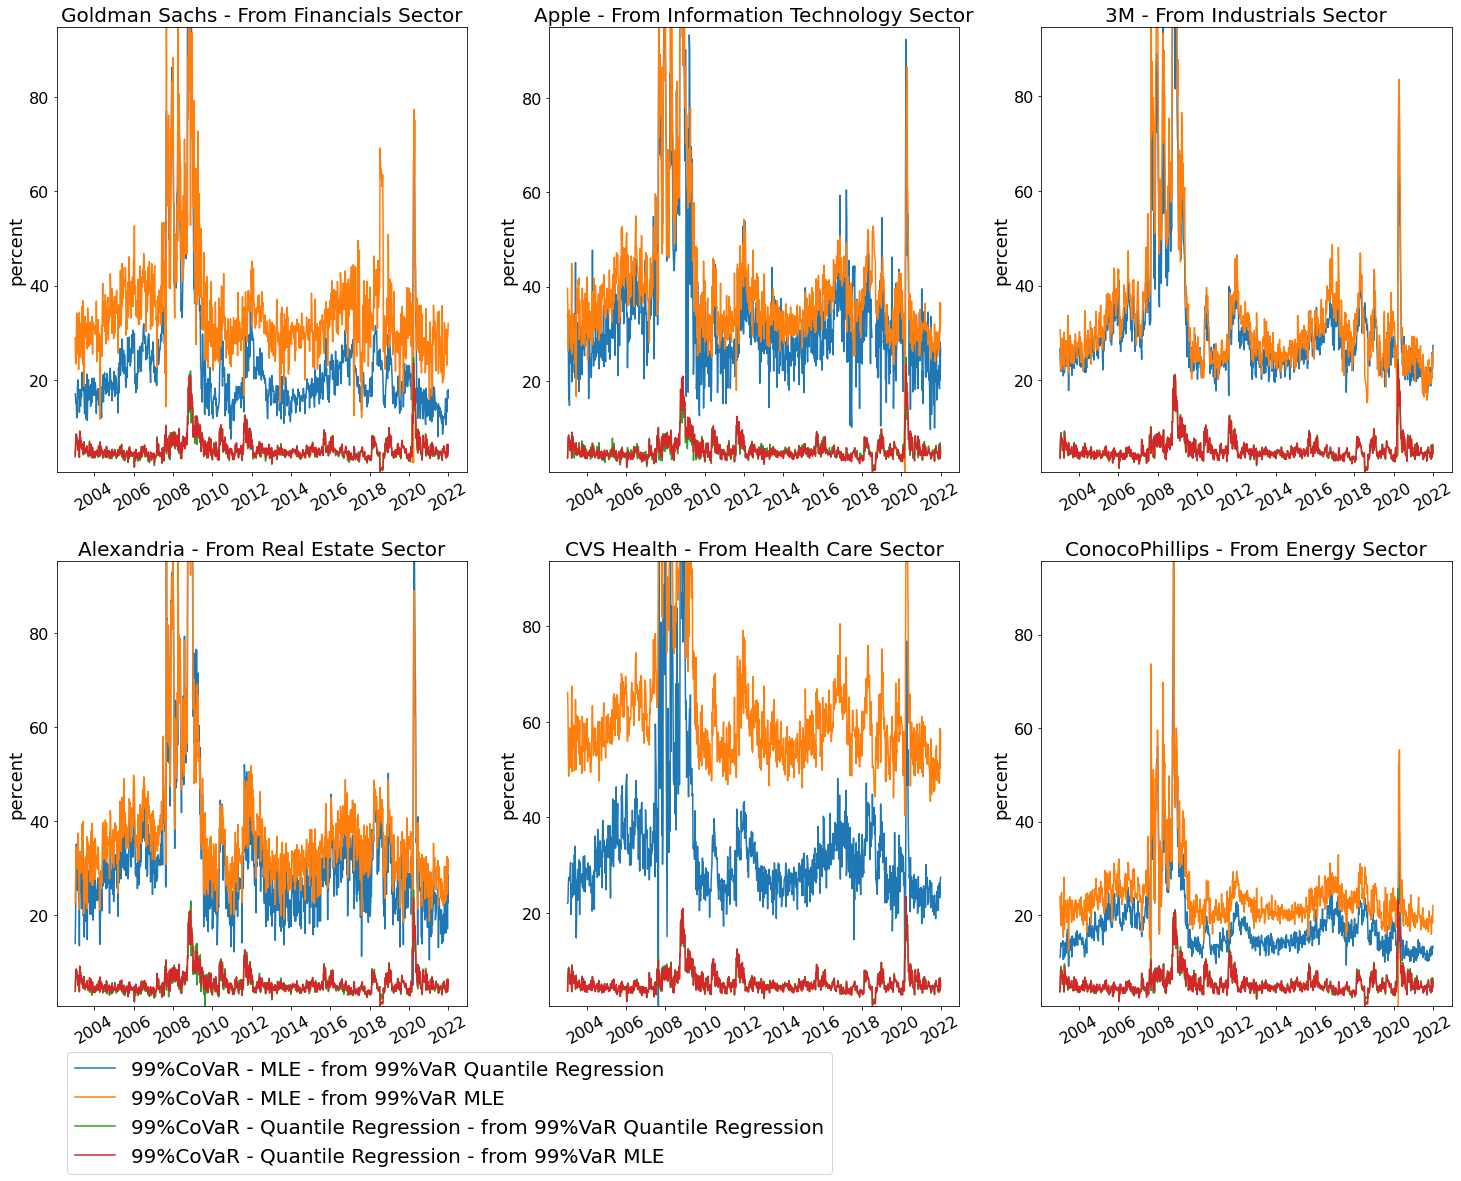

In [56]:
fig = plt.figure(figsize=(25, 18))
ax1 = fig.add_subplot(2, 3, 1)
covar_plot("GS", ax1)
ax2 = fig.add_subplot(2, 3, 2)
covar_plot("AAPL", ax2)
ax3 = fig.add_subplot(2, 3, 3)
covar_plot("MMM", ax3)
ax4 = fig.add_subplot(2, 3, 4)
covar_plot("ARE", ax4, add_legend = True)
ax5 = fig.add_subplot(2, 3, 5)
covar_plot("CVS", ax5)
ax6 = fig.add_subplot(2, 3, 6)
covar_plot("COP", ax6)

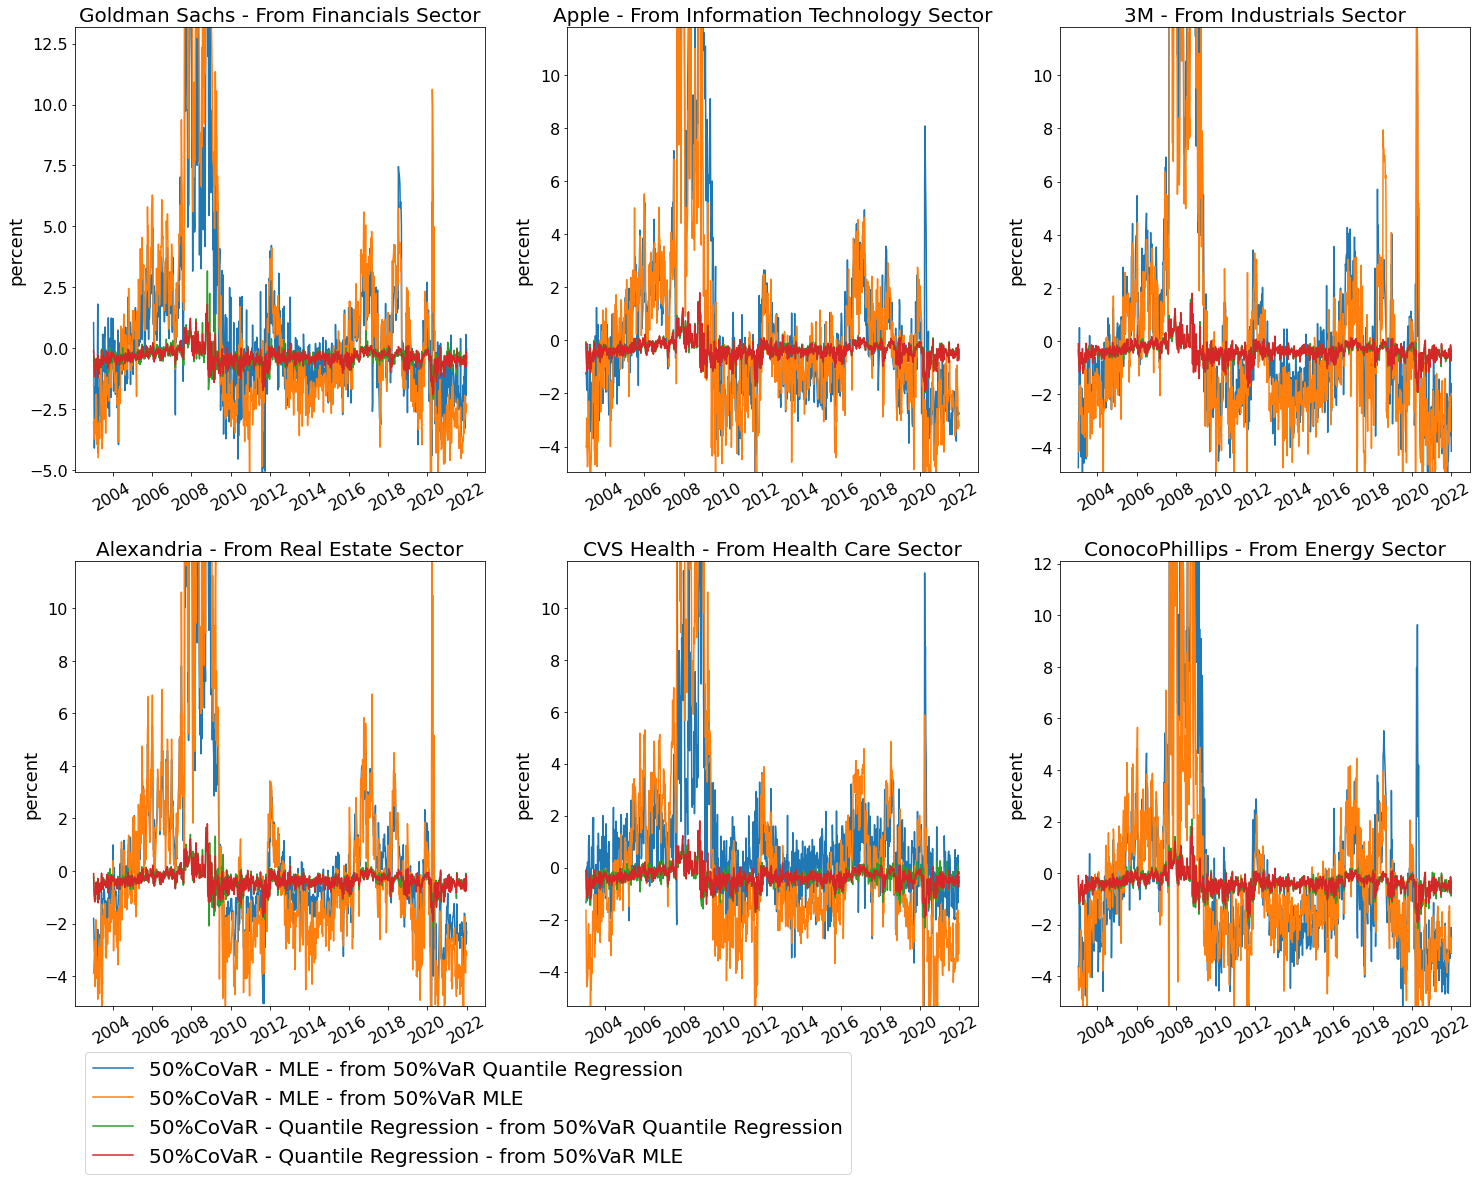

In [57]:
fig = plt.figure(figsize=(25, 18))
ax1 = fig.add_subplot(2, 3, 1)
covar_plot("GS", ax1, q = 0.5)
ax2 = fig.add_subplot(2, 3, 2)
covar_plot("AAPL", ax2, q = 0.5)
ax3 = fig.add_subplot(2, 3, 3)
covar_plot("MMM", ax3, q = 0.5)
ax4 = fig.add_subplot(2, 3, 4)
covar_plot("ARE", ax4, q = 0.5, add_legend = True)
ax5 = fig.add_subplot(2, 3, 5)
covar_plot("CVS", ax5, q = 0.5)
ax6 = fig.add_subplot(2, 3, 6)
covar_plot("COP", ax6, q = 0.5)

## $\Delta$CoVaR computational methods comparison

In [58]:
def delta_covar_plot(stock_name, ax, q = 0.99, sector = sector, add_legend = False):
    MLE_MLE = MLE_delta_covar(stock_name, q, MLE_var)[0]
    qr_MLE = MLE_delta_covar(stock_name, q, qr_var)[0]
    qr_qr_1 = qr_delta_covar(stock_name, q, qr_var, formula_alter = False)[0]
    qr_qr_2 = qr_delta_covar(stock_name, q, qr_var)[0]

    if stock_name in ["GS", "ARE"]:
        plot_min = np.array([qr_qr_1]).min() - 15
        plot_max = np.array([qr_qr_1]).max() + 40
    elif stock_name == "AAPL":
        plot_min = np.array([qr_qr_2]).min() + 100
        plot_max = np.array([MLE_MLE]).max() - 50
    elif stock_name == "MMM":
        plot_min = np.array([qr_qr_2]).min()
        plot_max = np.array([qr_qr_1]).max() + 30
    elif stock_name == "COP":
        plot_min = np.array([qr_qr_2]).min()
        plot_max = np.array([qr_qr_1]).max() + 10
    else:
        plot_min = np.array([qr_qr_2]).min()
        plot_max = np.array([qr_qr_1]).max() + 60

    plt.title(sector[sector.index == stock_name]["Security"].values[0] + " - From " + sector[sector.index == stock_name]["GICS\xa0Sector"].values[0] + " Sector", fontsize=20)
    plt.ylabel("percent", fontsize=18)
    plt.ylim(plot_min, plot_max)
    plt.xticks(fontsize=16, rotation = 30)
    plt.yticks(fontsize=16)
    if add_legend:
        ax.plot(qr_qr_1, label=str(int(100 *q)) + '%\u0394CoVaR - Quantile Regression - Formula1 - from 99%VaR Quantile Regression')
        ax.plot(qr_qr_2, label=str(int(100 *q)) + '%\u0394CoVaR - Quantile Regression - Formula2 - from 99%VaR Quantile Regression')
        ax.plot(qr_MLE, label=str(int(100 *q)) + '%\u0394CoVaR - MLE - from 99%VaR Quantile Regression')
        ax.plot(MLE_MLE, label=str(int(100 *q)) + '%\u0394CoVaR - MLE - from 99%VaR MLE')
        plt.legend(bbox_to_anchor=(0,-0.4), loc="lower left", fontsize=20)
    else:
        ax.plot(qr_qr_1)
        ax.plot(qr_qr_2)
        ax.plot(qr_MLE)
        ax.plot(MLE_MLE)

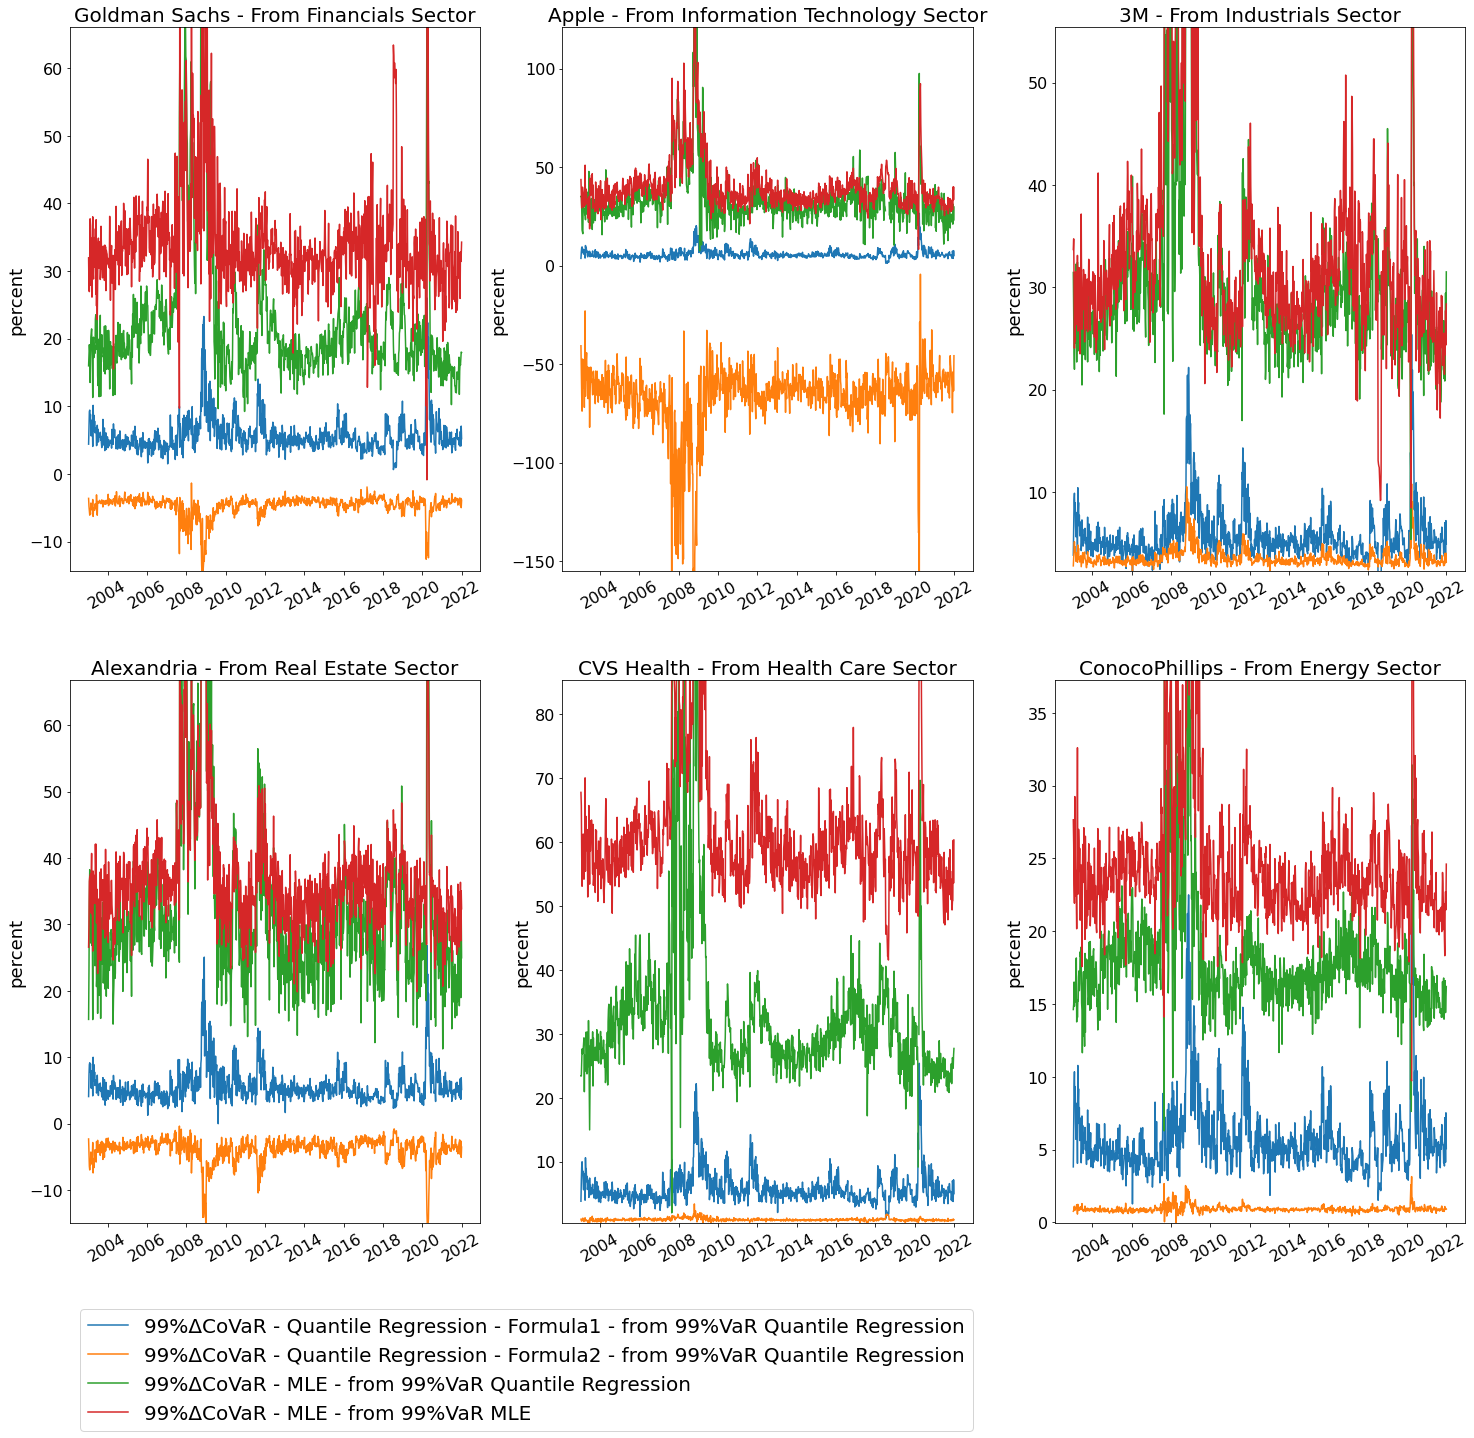

In [59]:
fig = plt.figure(figsize=(25, 22))
ax1 = fig.add_subplot(2, 3, 1)
delta_covar_plot("GS", ax1)
ax2 = fig.add_subplot(2, 3, 2)
delta_covar_plot("AAPL", ax2)
ax3 = fig.add_subplot(2, 3, 3)
delta_covar_plot("MMM", ax3)
ax4 = fig.add_subplot(2, 3, 4)
delta_covar_plot("ARE", ax4, add_legend = True)
ax5 = fig.add_subplot(2, 3, 5)
delta_covar_plot("CVS", ax5)
ax6 = fig.add_subplot(2, 3, 6)
delta_covar_plot("COP", ax6)

## $\Delta$CoVaR and VaR Results

In [60]:
def results_plot(stock_name, ax, q = 0.99, sector = sector, add_legend = False, market_losses_series = market_losses_W_pct):
    qr_modified = var(stock_name, q, qr_var)
    qr_qr = qr_delta_covar(stock_name, q, qr_var, formula_alter = False)[0]
    mkt = market_losses_series
    var_series = qr_modified
    delta_covar_series = qr_qr

    plt.title(sector[sector.index == stock_name]["Security"].values[0] + " - From " + sector[sector.index == stock_name]["GICS\xa0Sector"].values[0] + " Sector", fontsize=20)
    plt.ylabel("percent", fontsize=18)
    plt.xticks(fontsize=16, rotation = 30)
    plt.yticks(fontsize=16)
    if add_legend:
        ax.plot(mkt, label='Market Equity Loss')
        ax.plot(var_series, label=str(int(100 *q)) + '%\u0394CoVaR - Quantile Regression - Formula1 - from 99%VaR Quantile Regression')
        ax.plot(delta_covar_series, label=str(int(100 *q)) + '%VaR - Quantile Regression - Modified (Add lagged stock losses series)')
        plt.legend(bbox_to_anchor=(0,-0.4), loc="lower left", fontsize=20)
    else:
        ax.plot(mkt)
        ax.plot(var_series)
        ax.plot(delta_covar_series)

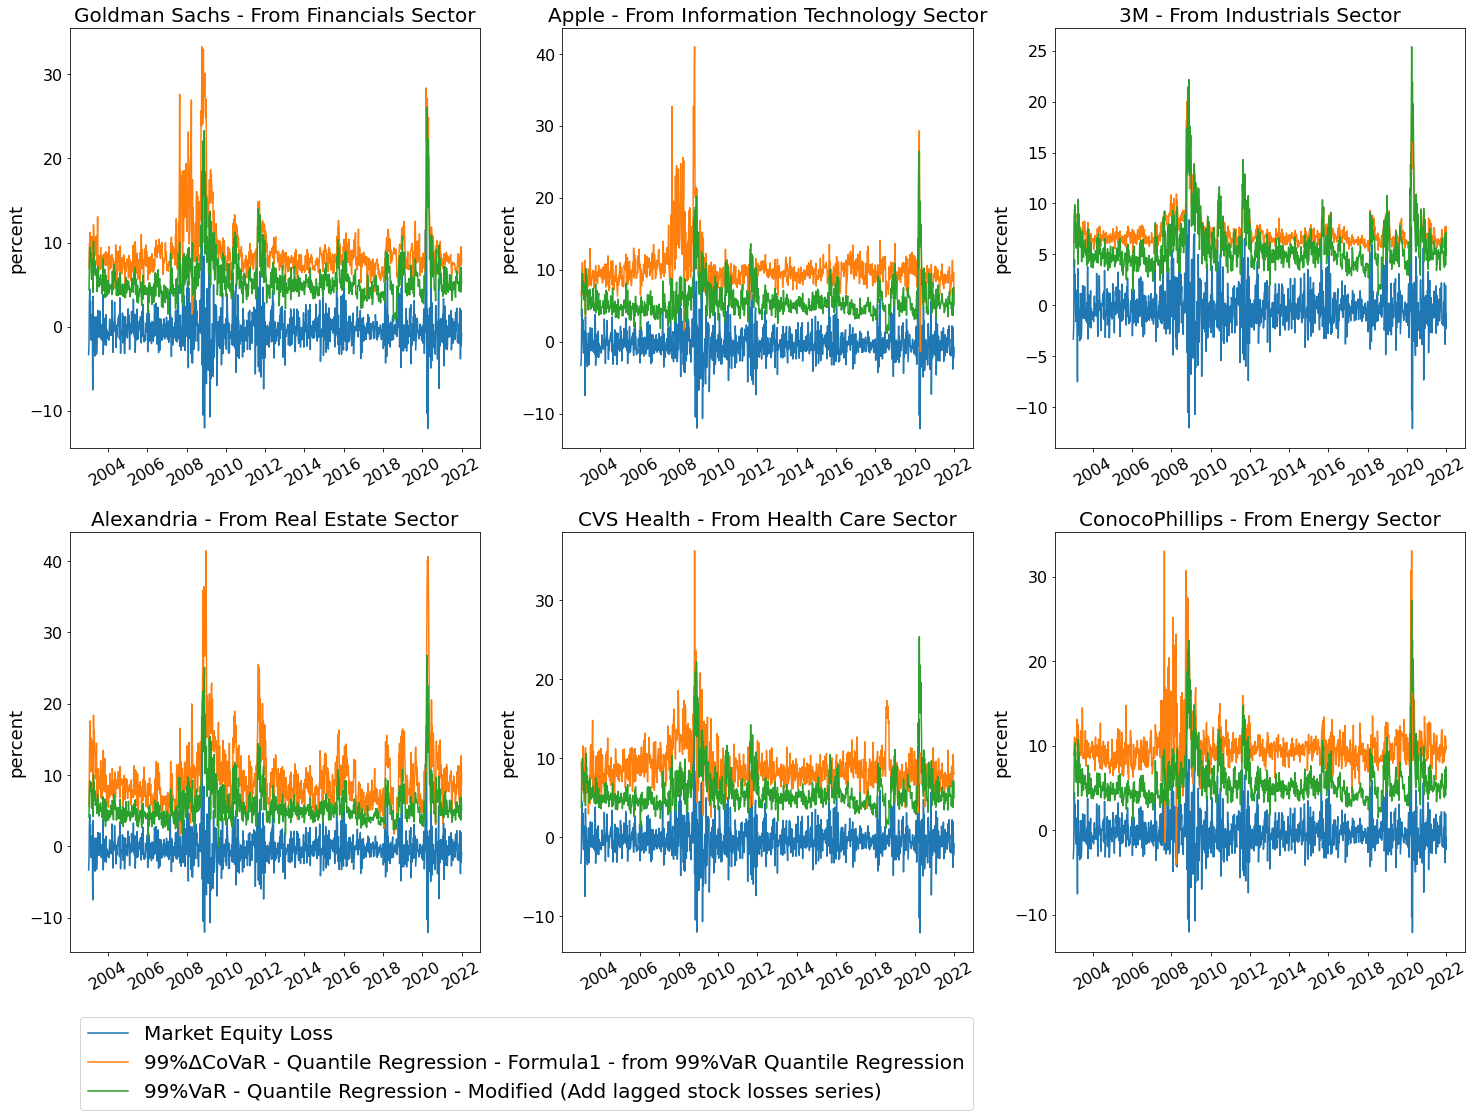

In [61]:
fig = plt.figure(figsize=(25, 17))
ax1 = fig.add_subplot(2, 3, 1)
results_plot("GS", ax1)
ax2 = fig.add_subplot(2, 3, 2)
results_plot("AAPL", ax2)
ax3 = fig.add_subplot(2, 3, 3)
results_plot("MMM", ax3)
ax4 = fig.add_subplot(2, 3, 4)
results_plot("ARE", ax4, add_legend = True)
ax5 = fig.add_subplot(2, 3, 5)
results_plot("CVS", ax5)
ax6 = fig.add_subplot(2, 3, 6)
results_plot("COP", ax6)

In [62]:
var_series_vec = pd.DataFrame(columns = list(stocks_losses_W_pct.columns))
delta_covar_series_vec = pd.DataFrame(columns = list(stocks_losses_W_pct.columns))
for stock_name in list(stocks_losses_W_pct.columns):
    delta_covar_series_vec[stock_name], var_series_vec[stock_name] = qr_delta_covar(stock_name, 0.99, qr_var, formula_alter = False)

C:\Users\Haochen Jiang\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Haochen Jiang\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Haochen Jiang\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Haochen Jiang\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Haochen Jiang\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\

In [63]:
var_series_vec_corr = var_series_vec.copy()
delta_covar_series_vec_corr = delta_covar_series_vec.copy()
var_series_vec_corr["Market"] = market_losses_W_pct
delta_covar_series_vec_corr["Market"] = market_losses_W_pct

In [64]:
def print_model_summary(stock_name):
    print(qr_var(stock_name, 0.99)[1].summary())
    print(qr_covar(stock_name, 0.99, qr_var)[1].summary())

In [65]:
output_list = ["GS", "AAPL", "MMM", "ARE", "CVS", "COP"]
for stock_name in output_list:
    print_model_summary(stock_name)

                         QuantReg Regression Results                          
Dep. Variable:                     GS   Pseudo R-squared:               0.3845
Model:                       QuantReg   Bandwidth:                       2.374
Method:                 Least Squares   Sparsity:                        107.9
Date:                Fri, 20 May 2022   No. Observations:                  991
Time:                        17:42:21   Df Residuals:                      982
                                        Df Model:                            8
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.0480      0.634      7.966      0.000       3.804       6.291
3MO_Yield_Change        -0.2192      0.068     -3.236      0.001      -0.352      -0.086
Term_Spread_Change       0.2333      0.328      0.711      0.477      -0.411       0.877
TE

## Sectors Analysis

In [66]:
sector_analyze1 = pd.DataFrame(index = ["\u0394CoVaR", "VaR", "Sector"], columns = list(delta_covar_series_vec.columns))
sector_analyze1.loc["VaR",:] = var_series_vec.iloc[-1,:]
sector_analyze1.loc["\u0394CoVaR",:] = delta_covar_series_vec.iloc[-1,:]
for stock_name in list(sector_analyze1.columns):
    sector_analyze1.loc["Sector", stock_name] = sector.loc[stock_name, "GICS\xa0Sector"]

In [67]:
sector_analyze2 = pd.DataFrame(index = ["\u0394CoVaR", "VaR", "Sector"], columns = list(delta_covar_series_vec.columns))
sector_analyze2.loc["VaR",:] = var_series_vec.iloc[-200,:]
sector_analyze2.loc["\u0394CoVaR",:] = delta_covar_series_vec.iloc[-200,:]
for stock_name in list(sector_analyze2.columns):
    sector_analyze2.loc["Sector", stock_name] = sector.loc[stock_name, "GICS\xa0Sector"]

In [68]:
sector_analyze3 = pd.DataFrame(index = ["\u0394CoVaR", "VaR", "Sector"], columns = list(delta_covar_series_vec.columns))
sector_analyze3.loc["VaR",:] = var_series_vec.iloc[-400,:]
sector_analyze3.loc["\u0394CoVaR",:] = delta_covar_series_vec.iloc[-400,:]
for stock_name in list(sector_analyze3.columns):
    sector_analyze3.loc["Sector", stock_name] = sector.loc[stock_name, "GICS\xa0Sector"]

In [69]:
sector_analyze4 = pd.DataFrame(index = ["\u0394CoVaR", "VaR", "Sector"], columns = list(delta_covar_series_vec.columns))
sector_analyze4.loc["VaR",:] = var_series_vec.iloc[-600,:]
sector_analyze4.loc["\u0394CoVaR",:] = delta_covar_series_vec.iloc[-600,:]
for stock_name in list(sector_analyze4.columns):
    sector_analyze4.loc["Sector", stock_name] = sector.loc[stock_name, "GICS\xa0Sector"]

In [70]:
sector_names = list(set(sector.loc[:, "GICS\xa0Sector"]))

In [71]:
def scatter(stock_name, ax, sector_analyze):
    ax.scatter(sector_analyze.loc["VaR", stock_name], sector_analyze.loc["\u0394CoVaR", stock_name])

Text(0, 0.5, '2022-01-02 ΔCoVaR (percent)')

Text(0.5, 0, '2022-01-02 VaR (percent)')

(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0, 0.5, '2018-03-11 ΔCoVaR (percent)')

Text(0.5, 0, '2018-03-11 VaR (percent)')

(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([ 6.,  7.,  8.,  9., 10., 11., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0, 0.5, '2014-05-11 ΔCoVaR (percent)')

Text(0.5, 0, '2014-05-11 VaR (percent)')

(array([ 2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0, 0.5, '2010-07-11 ΔCoVaR (percent)')

Text(0.5, 0, '2010-07-11 VaR (percent)')

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

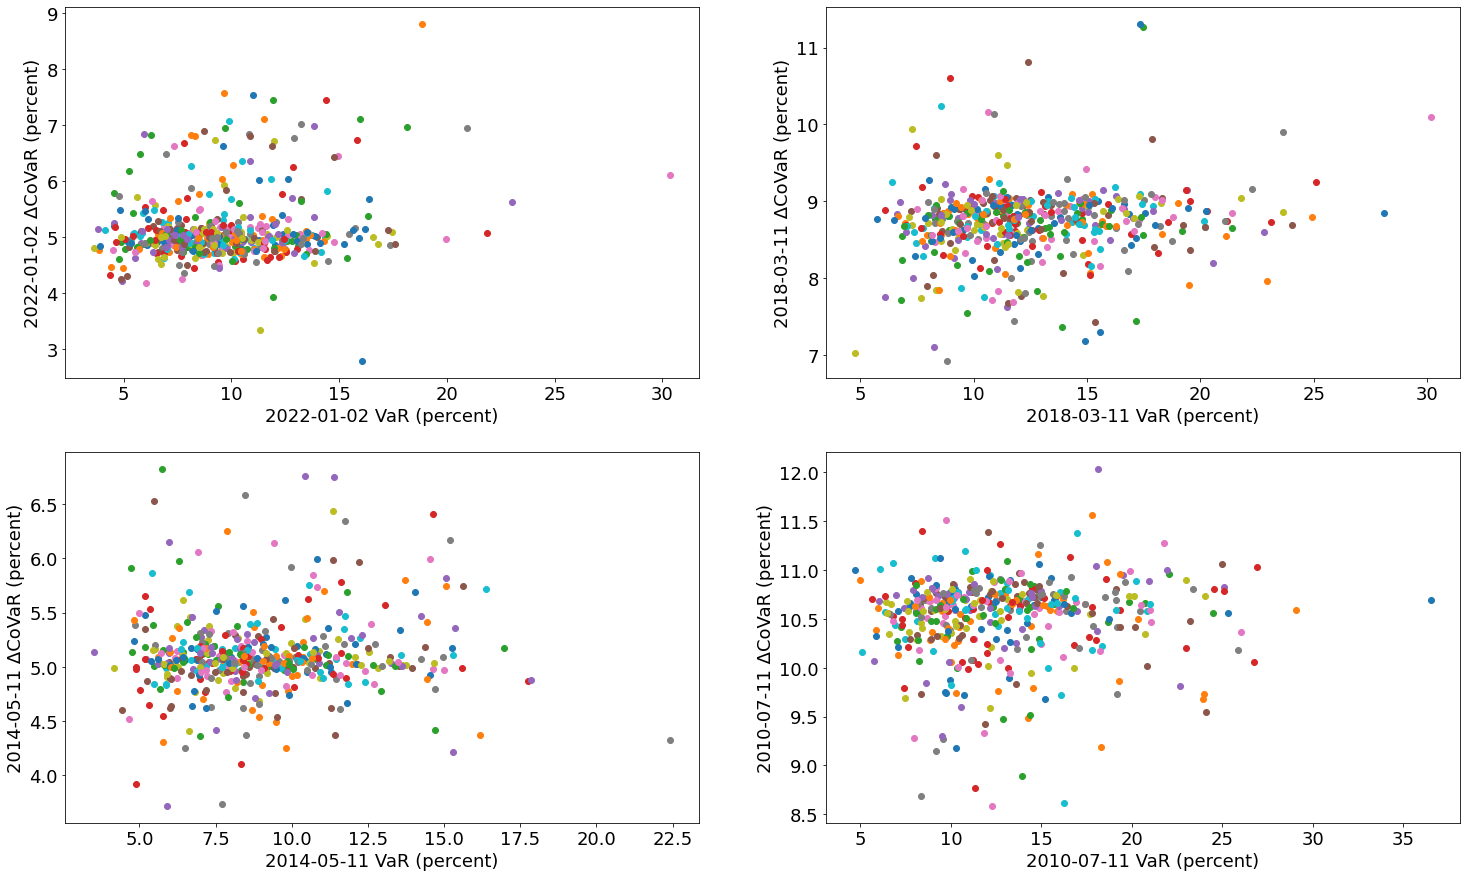

In [72]:
fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(2, 2, 1)
for i, stock_name in enumerate(list(delta_covar_series_vec.columns)):
    scatter(stock_name, ax1, sector_analyze1)
ax1.set_ylabel(str(var_series_vec.iloc[-1,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
ax1.set_xlabel(str(var_series_vec.iloc[-1,:].name)[:10] + " VaR (percent)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax2 = fig.add_subplot(2, 2, 2)
for i, stock_name in enumerate(list(delta_covar_series_vec.columns)):
    scatter(stock_name, ax2, sector_analyze2)
ax2.set_ylabel(str(var_series_vec.iloc[-200,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
ax2.set_xlabel(str(var_series_vec.iloc[-200,:].name)[:10] + " VaR (percent)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax3 = fig.add_subplot(2, 2, 3)
for i, stock_name in enumerate(list(delta_covar_series_vec.columns)):
    scatter(stock_name, ax3, sector_analyze3)
ax3.set_ylabel(str(var_series_vec.iloc[-400,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
ax3.set_xlabel(str(var_series_vec.iloc[-400,:].name)[:10] + " VaR (percent)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax4 = fig.add_subplot(2, 2, 4)
for i, stock_name in enumerate(list(delta_covar_series_vec.columns)):
    scatter(stock_name, ax4, sector_analyze4)
ax4.set_ylabel(str(var_series_vec.iloc[-600,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
ax4.set_xlabel(str(var_series_vec.iloc[-600,:].name)[:10] + " VaR (percent)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [73]:
diver_names = ["BAC", "C", "CMA", "JPM", "USB", "WFC"]
inves_names = ["SCHW", "GS", "MS"]
insur_names = ["AFL", "GL", "MET", "PFG", "PRU"]
consu_names = ["AXP", "COF", "DFS"]
names_list = [diver_names, inves_names, insur_names, consu_names]
color_list = ["b", "r", "k", "g"]
marker_list = ["o", "^", "v", "+"]
x_adjust_list_1 = list(np.array([-0.09,0.02,0.02,-0.15]) / 3.5)
y_adjust_list_1 = list(np.array([0.05,0.02,-0.1,-0.1]) / 3.5)
x_adjust_list_2 = list(np.array([-0.09,0.02,0.02,-0.15]) / 3)
y_adjust_list_2 = list(np.array([0.05,0.02,-0.1,-0.1]) / 3)
x_adjust_list_3 = list(np.array([-0.09,0.02,0.02,-0.15]) / 3)
y_adjust_list_3 = list(np.array([0.05,0.02,-0.1,-0.1]) / 3)
x_adjust_list_4 = list(np.array([-0.09,0.02,0.02,-0.15]) / 1.75)
y_adjust_list_4 = list(np.array([0.05,0.02,-0.1,-0.1]) / 1.75)
label_list = ["Diversified Banks", "Investment Banking & Brokerage", "Life & Health Insurance", "Consumer Finance"]

Text(11.025310660712211, 4.82812136839541, 'BAC')

Text(13.421559521066646, 4.979035634702523, 'C')

Text(8.940643752705556, 5.257030080622478, 'CMA')

Text(7.711832384028402, 4.796355613705203, 'JPM')

Text(9.737030807870857, 5.113862877769345, 'USB')

Text(11.400050661240021, 5.107966453609944, 'WFC')

Text(0, 0.5, '2022-01-02 ΔCoVaR (percent)')

Text(0.5, 0, '2022-01-02 VaR (percent)')

(array([ 7.,  8.,  9., 10., 11., 12., 13., 14.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(12.29585036493219, 4.669911982081618, 'SCHW')

Text(7.680631459012427, 5.218407387605862, 'GS')

Text(10.353227573635996, 5.0603515760902145, 'MS')

Text(0, 0.5, '2022-01-02 ΔCoVaR (percent)')

Text(0.5, 0, '2022-01-02 VaR (percent)')

(array([ 7.,  8.,  9., 10., 11., 12., 13., 14.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(9.060226969265976, 4.939146438018123, 'AFL')

Text(7.742283475028932, 4.713119199844882, 'GL')

Text(12.19892856228477, 4.610516305173214, 'MET')

Text(13.511206503170863, 5.039061230666232, 'PFG')

Text(11.52800768231981, 4.861341582983577, 'PRU')

Text(0, 0.5, '2022-01-02 ΔCoVaR (percent)')

Text(0.5, 0, '2022-01-02 VaR (percent)')

(array([ 7.,  8.,  9., 10., 11., 12., 13., 14.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(7.4351002224843175, 4.890064769818193, 'AXP')

Text(9.432803723849311, 5.155478354768496, 'COF')

Text(13.581254331112353, 4.751191938496731, 'DFS')

Text(0, 0.5, '2022-01-02 ΔCoVaR (percent)')

Text(0.5, 0, '2022-01-02 VaR (percent)')

(array([ 7.,  8.,  9., 10., 11., 12., 13., 14.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(20.131986218229223, 8.760081481155181, 'BAC')

Text(24.888072636816542, 8.807624149431197, 'C')

Text(14.021013034261369, 8.971395516970029, 'CMA')

Text(14.32498596770619, 8.740866189561215, 'JPM')

Text(14.890475231531685, 9.07177488824703, 'USB')

Text(18.27572473309401, 9.033305681457957, 'WFC')

Text(0, 0.5, '2018-03-11 ΔCoVaR (percent)')

Text(0.5, 0, '2018-03-11 VaR (percent)')

(array([12., 14., 16., 18., 20., 22., 24., 26.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([8.7 , 8.75, 8.8 , 8.85, 8.9 , 8.95, 9.  , 9.05, 9.1 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(15.48160856630338, 8.678045168025276, 'SCHW')

Text(10.616007271784305, 8.855706626165519, 'GS')

Text(14.161239852798857, 8.783066079421515, 'MS')

Text(0, 0.5, '2018-03-11 ΔCoVaR (percent)')

Text(0.5, 0, '2018-03-11 VaR (percent)')

(array([ 8., 10., 12., 14., 16., 18., 20., 22., 24., 26.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([8.65, 8.7 , 8.75, 8.8 , 8.85, 8.9 , 8.95, 9.  , 9.05, 9.1 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(14.769232386117627, 8.730793300730888, 'AFL')

Text(12.271475333445125, 8.827537956521093, 'GL')

Text(16.961892892341147, 8.538416183758494, 'MET')

Text(15.378391171125116, 9.00163511822203, 'PFG')

Text(18.58089892894169, 8.701827467890098, 'PRU')

Text(0, 0.5, '2018-03-11 ΔCoVaR (percent)')

Text(0.5, 0, '2018-03-11 VaR (percent)')

(array([ 8., 10., 12., 14., 16., 18., 20., 22., 24., 26.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(13.11567308377474, 8.909591330506819, 'AXP')

Text(17.248171577661473, 8.722397272138272, 'COF')

Text(15.5157580763464, 8.125946480216642, 'DFS')

Text(0, 0.5, '2018-03-11 ΔCoVaR (percent)')

Text(0.5, 0, '2018-03-11 VaR (percent)')

(array([ 8., 10., 12., 14., 16., 18., 20., 22., 24., 26.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([8. , 8.2, 8.4, 8.6, 8.8, 9. , 9.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(7.151432624081403, 5.024060892732647, 'BAC')

Text(9.87083118288218, 5.117279370709818, 'C')

Text(8.241366486998471, 5.065137864084337, 'CMA')

Text(8.417342977755897, 5.185929645014418, 'JPM')

Text(8.365886394576286, 5.145825507868754, 'USB')

Text(8.415880669613424, 5.012766179046504, 'WFC')

Text(0, 0.5, '2014-05-11 ΔCoVaR (percent)')

Text(0.5, 0, '2014-05-11 VaR (percent)')

(array([ 7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([4.975, 5.   , 5.025, 5.05 , 5.075, 5.1  , 5.125, 5.15 , 5.175,
        5.2  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(10.374770679266712, 5.235494893025883, 'SCHW')

Text(8.588579076974119, 5.008204739553072, 'GS')

Text(10.654966370095075, 5.033492875898108, 'MS')

Text(0, 0.5, '2014-05-11 ΔCoVaR (percent)')

Text(0.5, 0, '2014-05-11 VaR (percent)')

(array([ 7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(8.349601510704767, 4.937665045621567, 'AFL')

Text(5.690650448403877, 4.76226674910921, 'GL')

Text(9.181792442419702, 5.04972792424652, 'MET')

Text(8.15063776763811, 4.992270535683047, 'PFG')

Text(8.371127114398655, 4.917021164371584, 'PRU')

Text(0, 0.5, '2014-05-11 ΔCoVaR (percent)')

Text(0.5, 0, '2014-05-11 VaR (percent)')

(array([ 5.,  6.,  7.,  8.,  9., 10., 11.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(7.233721872969256, 5.009940666644258, 'AXP')

Text(9.114388167965599, 4.932822345843239, 'COF')

Text(10.774711116461464, 5.699000146322769, 'DFS')

Text(0, 0.5, '2014-05-11 ΔCoVaR (percent)')

Text(0.5, 0, '2014-05-11 VaR (percent)')

(array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([4.6, 4.8, 5. , 5.2, 5.4, 5.6, 5.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(20.78675312085043, 10.613580885937896, 'BAC')

Text(29.016092985467203, 10.618919829764092, 'C')

Text(15.791481015923965, 10.609698982917877, 'CMA')

Text(18.29142080134973, 10.248635633065433, 'JPM')

Text(19.041548533227648, 10.720554960260174, 'USB')

Text(20.43147253026597, 10.673783204286163, 'WFC')

Text(0, 0.5, '2010-07-11 ΔCoVaR (percent)')

Text(0.5, 0, '2010-07-11 VaR (percent)')

(array([14., 16., 18., 20., 22., 24., 26., 28., 30.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(14.54128609981466, 9.80415218968195, 'SCHW')

Text(10.40050649349813, 10.770722295123342, 'GS')

Text(12.725378200053102, 10.917827707067199, 'MS')

Text(0, 0.5, '2010-07-11 ΔCoVaR (percent)')

Text(0.5, 0, '2010-07-11 VaR (percent)')

(array([ 7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. , 27.5, 30. , 32.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([ 9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(18.68252779301686, 10.41043047019693, 'AFL')

Text(14.57564192657578, 10.784625828216019, 'GL')

Text(17.785514972282595, 10.565045499630836, 'MET')

Text(16.014753039800045, 10.722727118997534, 'PFG')

Text(19.372434290538106, 10.53910257540016, 'PRU')

Text(0, 0.5, '2010-07-11 ΔCoVaR (percent)')

Text(0.5, 0, '2010-07-11 VaR (percent)')

(array([ 7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. , 27.5, 30. , 32.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([ 9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(15.646612316575755, 10.655770652771997, 'AXP')

Text(19.824680758119793, 10.93338707515407, 'COF')

Text(11.717591426458574, 9.276150104897201, 'DFS')

Text(0, 0.5, '2010-07-11 ΔCoVaR (percent)')

Text(0.5, 0, '2010-07-11 VaR (percent)')

(array([ 7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. , 27.5, 30. , 32.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([ 9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  , 11.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

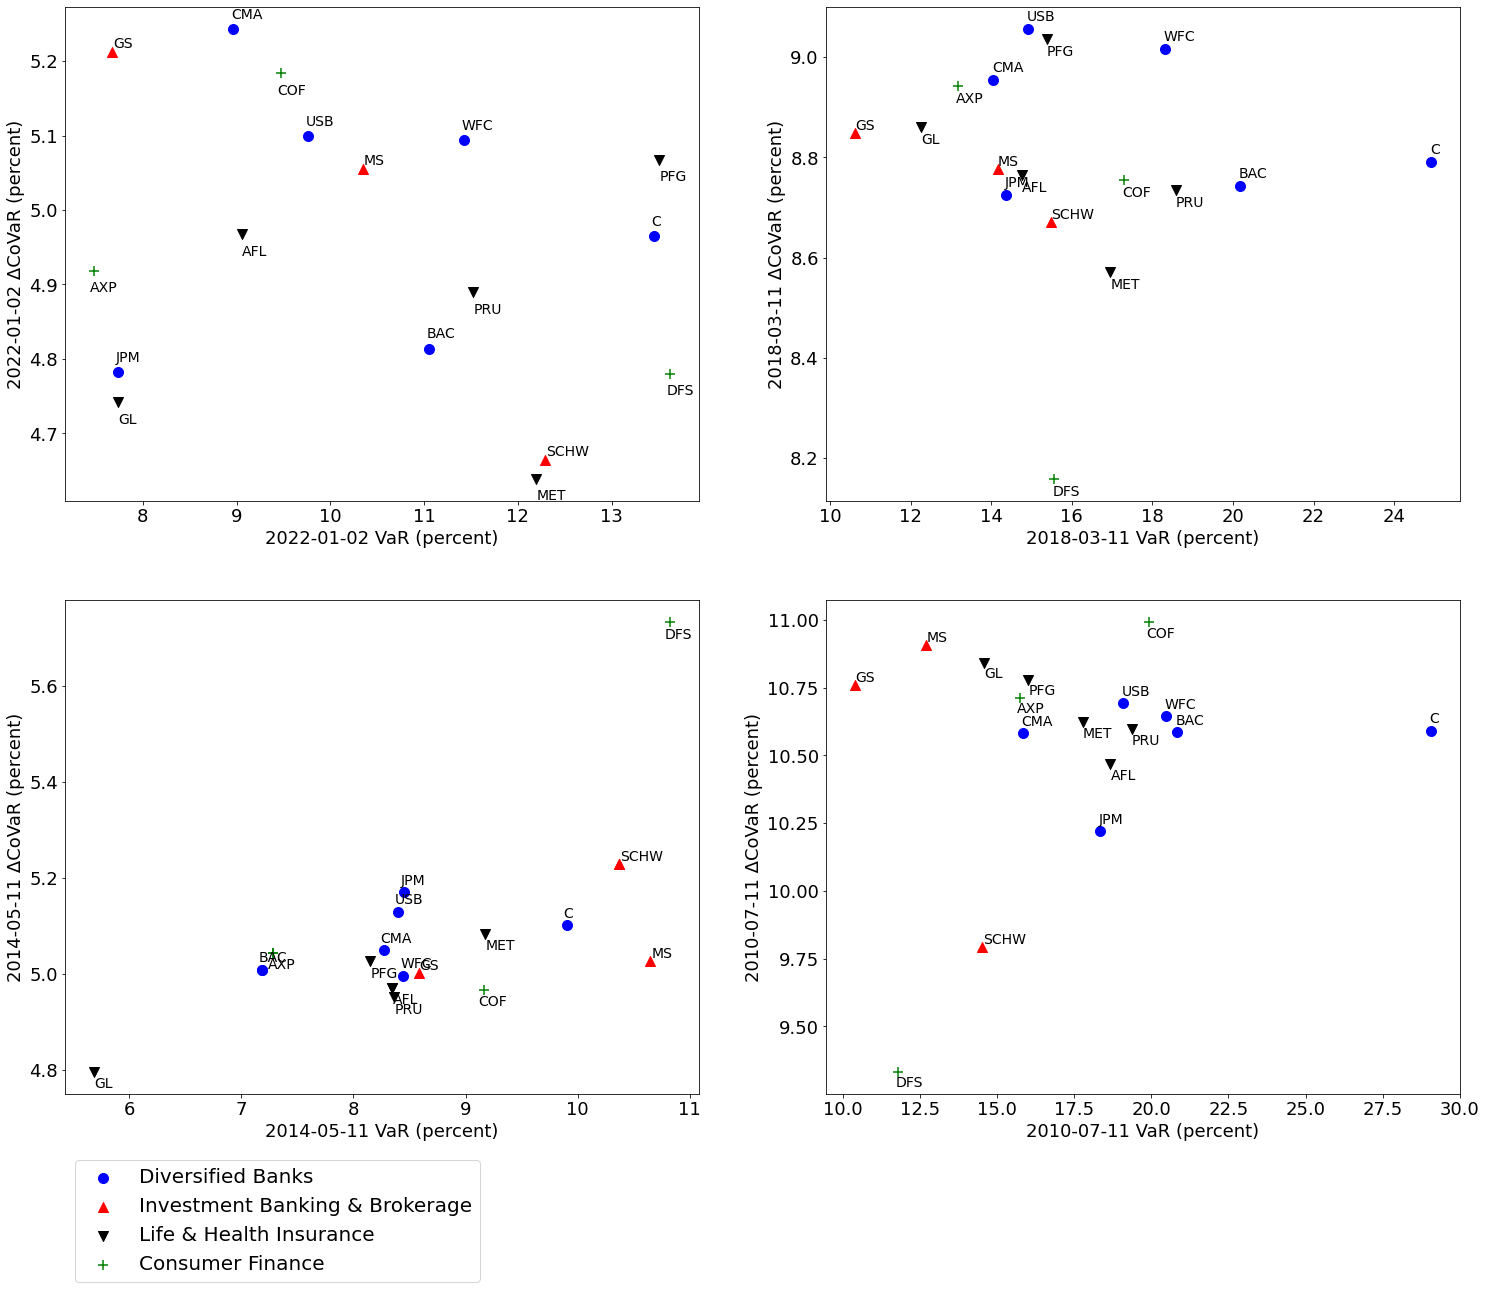

In [74]:
fig = plt.figure(figsize=(25, 20))
ax1 = fig.add_subplot(2, 2, 1)
for i, stock_name_list in enumerate(names_list):
    for stock_name in stock_name_list:
        ax1.scatter(sector_analyze1.loc["VaR", stock_name], 
                    sector_analyze1.loc["\u0394CoVaR", stock_name], 
                    color = color_list[i], s = 100, 
                    marker = marker_list[i])
        plt.text(sector_analyze1.loc["VaR", stock_name] + x_adjust_list_1[i], 
                 sector_analyze1.loc["\u0394CoVaR", stock_name] + y_adjust_list_1[i],
                 stock_name, fontsize=14)
    ax1.set_ylabel(str(var_series_vec.iloc[-1,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
    ax1.set_xlabel(str(var_series_vec.iloc[-1,:].name)[:10] + " VaR (percent)", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

ax2 = fig.add_subplot(2, 2, 2)
for i, stock_name_list in enumerate(names_list):
    for stock_name in stock_name_list:
        ax2.scatter(sector_analyze2.loc["VaR", stock_name], 
                    sector_analyze2.loc["\u0394CoVaR", stock_name], 
                    color = color_list[i], s = 100, 
                    marker = marker_list[i])
        plt.text(sector_analyze2.loc["VaR", stock_name] + x_adjust_list_2[i], 
                 sector_analyze2.loc["\u0394CoVaR", stock_name] + y_adjust_list_2[i],
                 stock_name, fontsize=14)
    ax2.set_ylabel(str(var_series_vec.iloc[-200,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
    ax2.set_xlabel(str(var_series_vec.iloc[-200,:].name)[:10] + " VaR (percent)", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

ax3 = fig.add_subplot(2, 2, 3)
for i, stock_name_list in enumerate(names_list):
    for stock_name in stock_name_list:
        ax3.scatter(sector_analyze3.loc["VaR", stock_name], 
                    sector_analyze3.loc["\u0394CoVaR", stock_name], 
                    color = color_list[i], s = 100, 
                    marker = marker_list[i])
        plt.text(sector_analyze3.loc["VaR", stock_name] + x_adjust_list_3[i], 
                 sector_analyze3.loc["\u0394CoVaR", stock_name] + y_adjust_list_3[i],
                 stock_name, fontsize=14)
    ax3.set_ylabel(str(var_series_vec.iloc[-400,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
    ax3.set_xlabel(str(var_series_vec.iloc[-400,:].name)[:10] + " VaR (percent)", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
ax3.scatter(sector_analyze3.loc["VaR", "BAC"],  sector_analyze3.loc["\u0394CoVaR", "BAC"], 
            color = color_list[0], s = 100, marker = marker_list[0], label = label_list[0])
ax3.scatter(sector_analyze3.loc["VaR", "SCHW"],  sector_analyze3.loc["\u0394CoVaR", "SCHW"], 
            color = color_list[1], s = 100, marker = marker_list[1], label = label_list[1])
ax3.scatter(sector_analyze3.loc["VaR", "AFL"],  sector_analyze3.loc["\u0394CoVaR", "AFL"], 
            color = color_list[2], s = 100, marker = marker_list[2], label = label_list[2])
ax3.scatter(sector_analyze3.loc["VaR", "AXP"],  sector_analyze3.loc["\u0394CoVaR", "AXP"], 
            color = color_list[3], s = 100, marker = marker_list[3], label = label_list[3])
plt.legend(bbox_to_anchor=(0,-0.4), loc="lower left", fontsize=20)

ax4 = fig.add_subplot(2, 2, 4)
for i, stock_name_list in enumerate(names_list):
    for stock_name in stock_name_list:
        ax4.scatter(sector_analyze4.loc["VaR", stock_name], 
                    sector_analyze4.loc["\u0394CoVaR", stock_name], 
                    color = color_list[i], s = 100, 
                    marker = marker_list[i])
        plt.text(sector_analyze4.loc["VaR", stock_name] + x_adjust_list_4[i], 
                 sector_analyze4.loc["\u0394CoVaR", stock_name] + y_adjust_list_4[i],
                 stock_name, fontsize=14)
    ax4.set_ylabel(str(var_series_vec.iloc[-600,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
    ax4.set_xlabel(str(var_series_vec.iloc[-600,:].name)[:10] + " VaR (percent)", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

In [75]:
def sector_plot(ax, j, sector_analyze, legend = False, sector_names = sector_names, v = var_series_vec):
    color_list = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', "black"]
    for i, sector_name in enumerate(sector_names):
        temp = sector_analyze.loc[:, sector_analyze.loc["Sector",:] == sector_name]
        ax.scatter(temp.loc["VaR"], temp.loc["\u0394CoVaR"], color = color_list[i], label = sector_name)
        ax.set_ylabel(str(v.iloc[-j,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
        ax.set_xlabel(str(v.iloc[-j,:].name)[:10] + " VaR (percent)", fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if legend:
            plt.legend(bbox_to_anchor=(0,-0.9), loc="lower left", fontsize=20)

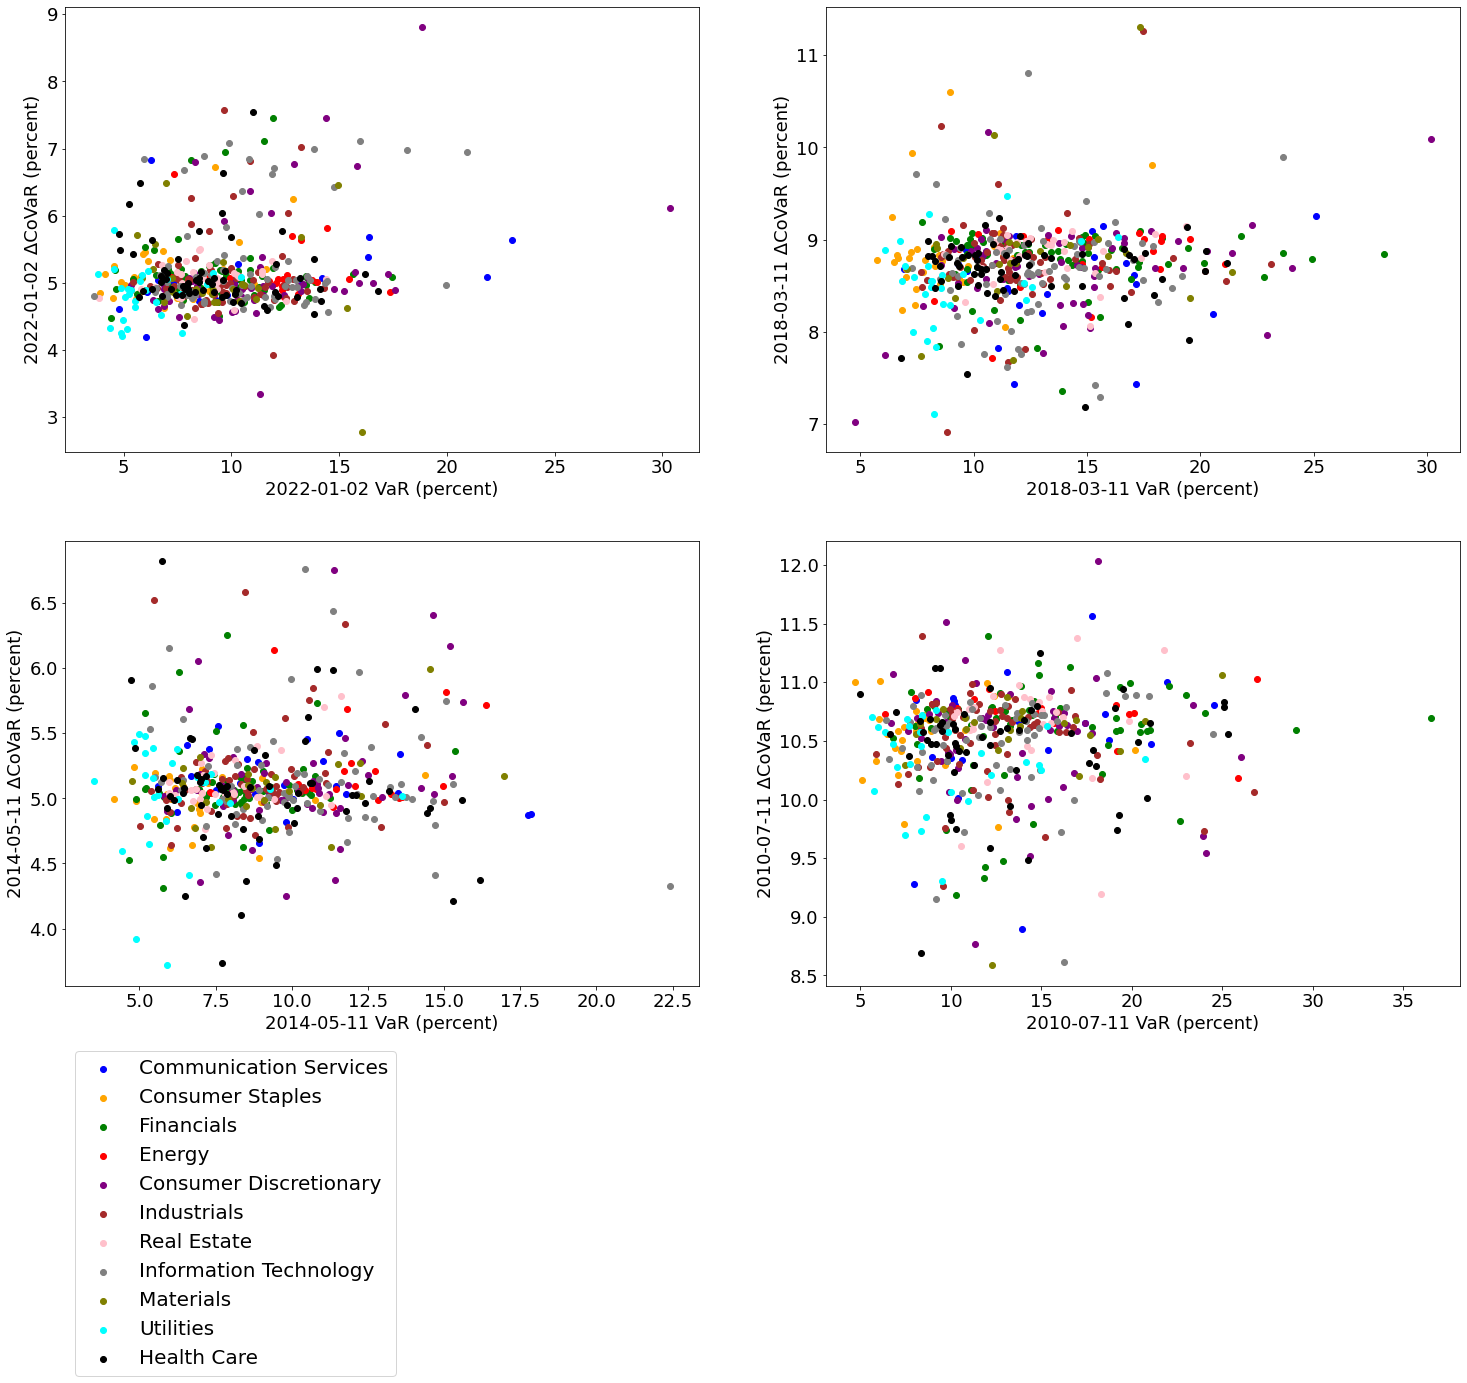

In [76]:
fig = plt.figure(figsize=(25, 18))
ax1 = fig.add_subplot(2, 2, 1)
sector_plot(ax1, 1, sector_analyze1)
ax2 = fig.add_subplot(2, 2, 2)
sector_plot(ax2, 200, sector_analyze2)
ax3 = fig.add_subplot(2, 2, 3)
sector_plot(ax3, 400, sector_analyze3, legend = True)
ax4 = fig.add_subplot(2, 2, 4)
sector_plot(ax4, 600, sector_analyze4)

# Appendix

formula_alternative Data Resources:\
#1 FRED-DTB3 - 3months Fred Treasury bill rate in secondary market
https://www.quandl.com/data/FRED/DTB3-3-Month-Treasury-Bill-Secondary-Market-Rate
\
#2 USTREASURY-LONGTERMRATES - Composite Long term bond yield
https://www.quandl.com/data/USTREASURY/LONGTERMRATES-Treasury-Long-Term-Rates
\
#3 USTREASURY-LONGTERMRATES - 3 months libor rate
https://www.quandl.com/data/FRED/LIOR3M-3-month-London-Interbank-Offered-Rate-LIBOR
\
#4 FRED-DGS3MO -  3 months tbill constant maturity rate
https://www.quandl.com/data/FRED/DGS3MO-3-Month-Treasury-Constant-Maturity-Rate
\
#5 Change in Credit Spread
https://research.stlouisfed.org/useraccount/datalists/250349